# Provide A/B test

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
random.seed(0)

**Part I - Probability**

**Part II - A/B Test**

**Part III - Regression**

**For this project, I will be working to understand the results of A/B test run by an e-commerce website.**


**My goal in this work to help company understand if they should implement the new page, keep old, or continue searching new decision.**

Read in the dataset and take a look at the top few rows here:

- user_id: Уникальный идентификатор пользователя.
- timestamp: Временная метка, указывающая на время события.
- group: Группа, к которой относится пользователь (контрольная или тестовая).
- landing_page: Страница, на которую был направлен пользователь (старая страница или новая страница).
- converted: Флаг, указывающий, было ли событие конверсией (1 - да, 0 - нет).

In [54]:
countries = pd.read_csv('D:/загрузки/countries.csv')
ab_data = pd.read_csv('D:/загрузки/ab_data.csv')
ab_data.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [82]:
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [55]:
ab_data.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

 Use the cell below to find the number of rows in the dataset.

In [56]:
ab_data.shape

(294478, 5)

У нас есть дубликаты в данных

In [57]:
ab_data['user_id'].nunique()
delta = np.abs(ab_data['user_id'].nunique() - len(ab_data['user_id']))
print(f"The number of duplicates is {delta}")

The number of duplicates is 3894


The proportion of users converted

In [58]:
converted = len(ab_data[ab_data['converted'] == 1]) /  len(ab_data['converted'])
print(f"Proportion of converted: {converted}")

Proportion of converted: 0.11965919355605512


Половина аудитории увидит старую страницу, а половина новую 

In [59]:
ab_data['landing_page'].value_counts()

landing_page
old_page    147239
new_page    147239
Name: count, dtype: int64

In [60]:
ab_data['group'].value_counts()

group
treatment    147276
control      147202
Name: count, dtype: int64

Рассмотрим те случаи когда по какой-то причине тестовая выборка не увидела новую страницу, а так же контрольные пользователи увидели новую страницу 

In [61]:
first_time_error = ab_data.query('group == "treatment" and landing_page == "old_page"')
second_time_error = ab_data.query('group == "control" and landing_page == "new_page"')
print(f"Number of noise elements: {len(first_time_error) + len(second_time_error)}")


Number of noise elements: 3893


Do any of the rows have missing values?

In [62]:
first_time_error.head()

,user_id,timestamp,group,landing_page,converted
308,857184,2017-01-20 07:34:59.832626,treatment,old_page,0
327,686623,2017-01-09 14:26:40.734775,treatment,old_page,0
357,856078,2017-01-12 12:29:30.354835,treatment,old_page,0
685,666385,2017-01-23 08:11:54.823806,treatment,old_page,0
713,748761,2017-01-10 15:47:44.445196,treatment,old_page,0


In [63]:
df_to_remove = first_time_error.copy()
df_to_remove = pd.concat([df_to_remove, second_time_error])
df_to_remove.head()

,user_id,timestamp,group,landing_page,converted
308,857184,2017-01-20 07:34:59.832626,treatment,old_page,0
327,686623,2017-01-09 14:26:40.734775,treatment,old_page,0
357,856078,2017-01-12 12:29:30.354835,treatment,old_page,0
685,666385,2017-01-23 08:11:54.823806,treatment,old_page,0
713,748761,2017-01-10 15:47:44.445196,treatment,old_page,0


In [64]:
df = ab_data.drop(df_to_remove.index)
df.drop_duplicates(inplace=True)
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [65]:
df.shape

(290585, 5)

In [66]:
# Double Check all of the correct rows were removed - this should be 0
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

0

Приведем время к привычному формату 

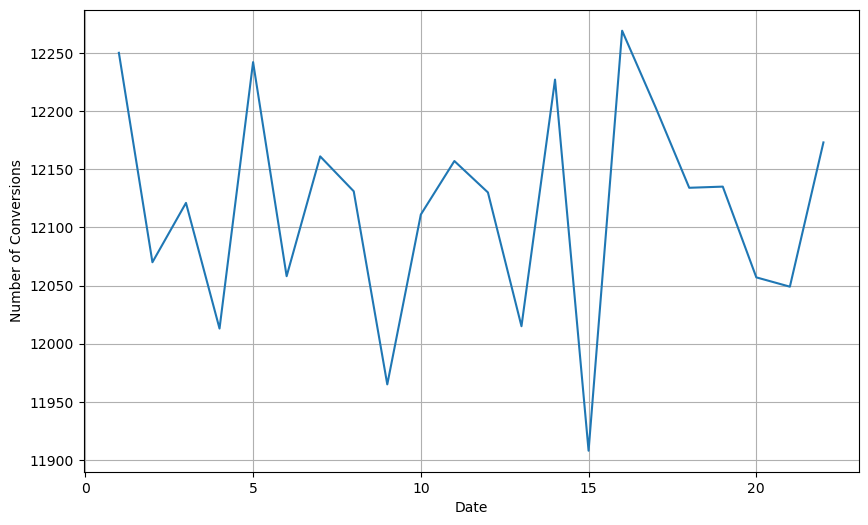

In [79]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['date'] = df['timestamp'].dt.date
df['hour'] = df['timestamp'].dt.hour
conversions_by_day = df.groupby('date')['converted'].count()
hourly_grouped_data = df.groupby('hour')['converted'].count()
conversions_by_day_1 = df[df['converted'] == 1].groupby('date')['converted'].sum()
conversions_by_day_0 = df[df['converted'] == 0].groupby('date')['converted'].count()

hourly_grouped_data[1:-1].plot(kind = 'line', figsize = (10, 6))
plt.xlabel('Date')
plt.ylabel('Number of Conversions')
plt.grid(True)
plt.show()

на глаз не видно никакой временной зависимости: ни сезонности ни тренда ни циклов

In [73]:
min_timestamp = df['timestamp'].min()
max_timestamp = df['timestamp'].max()

print("Временной промежуток эксперимента:")
print("Начало:", min_timestamp)
print("Конец:", max_timestamp)

Временной промежуток эксперимента:
Начало: 2017-01-02 13:42:05.378582
Конец: 2017-01-24 13:41:54.460509


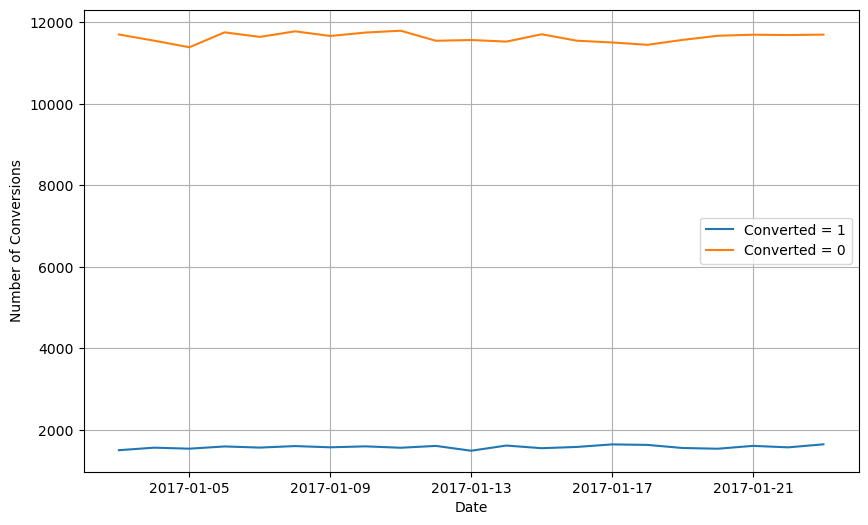

In [74]:
conversions_by_day_1[1:-1].plot(kind='line', figsize=(10, 6), label='Converted = 1')
conversions_by_day_0[1:-1].plot(kind='line', figsize=(10, 6), label='Converted = 0')
plt.xlabel('Date')
plt.ylabel('Number of Conversions')
plt.legend()
plt.grid(True)
plt.show()


In [80]:
df['converted'].value_counts(normalize= True)

converted
0    0.880403
1    0.119597
Name: proportion, dtype: float64

Given that an individual was in the control group, what is the probability they converted?

In [93]:
control_conversions_by_day = df[df['group'] == 'control'].groupby('date')['converted'].mean()
test_conversion_by_day = df[df['group'] == 'treatment'].groupby('date')['converted'].mean()
control_conversions_by_day = control_conversions_by_day.to_list()
test_conversion_by_day = test_conversion_by_day.to_list()
type(test_conversion_by_day)

list

https://studfile.net/preview/16712870/page:22/

In [94]:
from scipy import stats

statistic, p_value = stats.shapiro(control_conversions_by_day)

print("Statistic:", statistic)
print("p-value:", p_value)

# Интерпретация результата
alpha = 0.05
if p_value > alpha:
    print("Не удалось отвергнуть нулевую гипотезу (данные подчиняются нормальному распределению)")
else:
    print("Отвергаем нулевую гипотезу (данные не подчиняются нормальному распределению)")

Statistic: 0.9680882096290588
p-value: 0.6433432698249817
Не удалось отвергнуть нулевую гипотезу (данные подчиняются нормальному распределению)


In [95]:
statistic, p_value = stats.shapiro(test_conversion_by_day)

print("Statistic:", statistic)
print("p-value:", p_value)

# Интерпретация результата
alpha = 0.05
if p_value > alpha:
    print("Не удалось отвергнуть нулевую гипотезу (данные подчиняются нормальному распределению)")
else:
    print("Отвергаем нулевую гипотезу (данные не подчиняются нормальному распределению)")

Statistic: 0.9816673398017883
p-value: 0.9324821829795837
Не удалось отвергнуть нулевую гипотезу (данные подчиняются нормальному распределению)


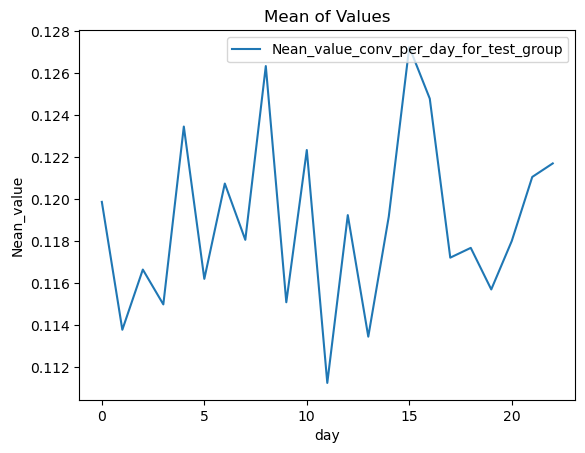

In [98]:
plt.plot(test_conversion_by_day, label='Nean_value_conv_per_day_for_test_group')
plt.xlabel('day')
plt.ylabel('Nean_value')
plt.title('Mean of Values')
plt.legend()
plt.show()

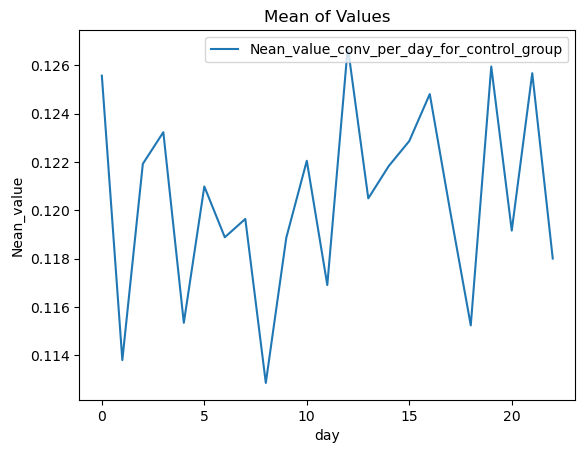

In [99]:
plt.plot(control_conversions_by_day, label='Nean_value_conv_per_day_for_control_group')
plt.xlabel('day')
plt.ylabel('Nean_value')
plt.title('Mean of Values')
plt.legend()
plt.show()

In [101]:
from scipy import stats

# Проведение t-теста
t_statistic, p_value = stats.ttest_ind(test_conversion_by_day, control_conversions_by_day)

# Вывод результатов
print("t-статистика:", t_statistic)
print("p-значение:", p_value)

alpha = 0.05
if p_value < alpha:
    print('Мы имеет достаочной аргументы в сторону отвержения H0 и принятия альтернативы')
else:
    print('У нас нет достаточных оснований отвергать H0 соответсвенно мат ожидания в выборках можно считать одинаковый с долей вероятности 95%')


t-статистика: -1.333241235172402
p-значение: 0.18931462543655247
У нас нет достаточных оснований отвергать H0 соответсвенно мат ожидания в выборках можно считать одинаковый с долей вероятности 95%


Part II - A/B Test
1. For now, consider you need to make the decision just based on all the data provided. If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be? You can state your hypothesis in terms of words or in terms of 
 and 
, which are the converted rates for the old and new pages.

Null: uP_new - uP_old <= 0

ALT: uP_new - uP_old > 0

2. Assume under the null hypothesis, 
 and 
 both have "true" success rates equal to the converted success rate regardless of page - that is 
 and 
 are equal. Furthermore, assume they are equal to the converted rate in ab_data.csv regardless of the page.

In [103]:
# We are looking at a null where there is no difference in conversion based
# on page, which means the conversions for each page are the same.
p_new = df.converted.mean()
p_new

0.11959667567149027

In [105]:
# We are looking at a null where there is no difference in conversion based
# on page, which means the conversions for each page are the same.
p_old = df.converted.mean()
p_old

0.11959667567149027

In [106]:
# show that there is no difference in conversion based on page
p_new - p_old

0.0

In [107]:
n_new = len(df[df.group == 'treatment'])
n_new

145311

In [108]:
n_old = len(df[df.group == 'control'])
n_old

145274

Simulate n_new
 transactions with a conversion rate of p_new
 under the null. Store these n_new
 1's and 0's in new_page_converted

In [111]:
new_page_converted = []
new_page_converted = np.random.choice([0,1],n_new,[1-p_new,p_new])

Simulate n_old
 transactions with a conversion rate of p_old
 under the null. Store these n_old
 1's and 0's in new_page_converted

In [112]:
old_page_converted = []
old_page_converted = np.random.choice([0,1],n_old,[1-p_old,p_old])

In [113]:
#new_page_converted.mean() - old_page_converted.mean()
obs_diff = np.mean(new_page_converted) - np.mean(old_page_converted)
obs_diff

3.547812342186152e-06

In [114]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

#mpl.style.use('ggplot')
%matplotlib inline

In [116]:
p_diffs = np.array(0)
new_page_converted = []
old_page_converted = []

for _ in range(1000):
    bootsamp2 = df.sample(n_new, replace=True)
    new_page_converted = np.random.choice([0,1],n_new,[1-p_new,p_new])
    old_page_converted = np.random.choice([0,1],n_old,[1-p_old,p_old])
    diff = np.mean(new_page_converted) - np.mean(old_page_converted)
    p_diffs = np.append(p_diffs, diff)

C:\Users\User\AppData\Local\Temp\ipykernel_3084\4138752242.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(p_diffs, bins=10, kde=False, rug=True);


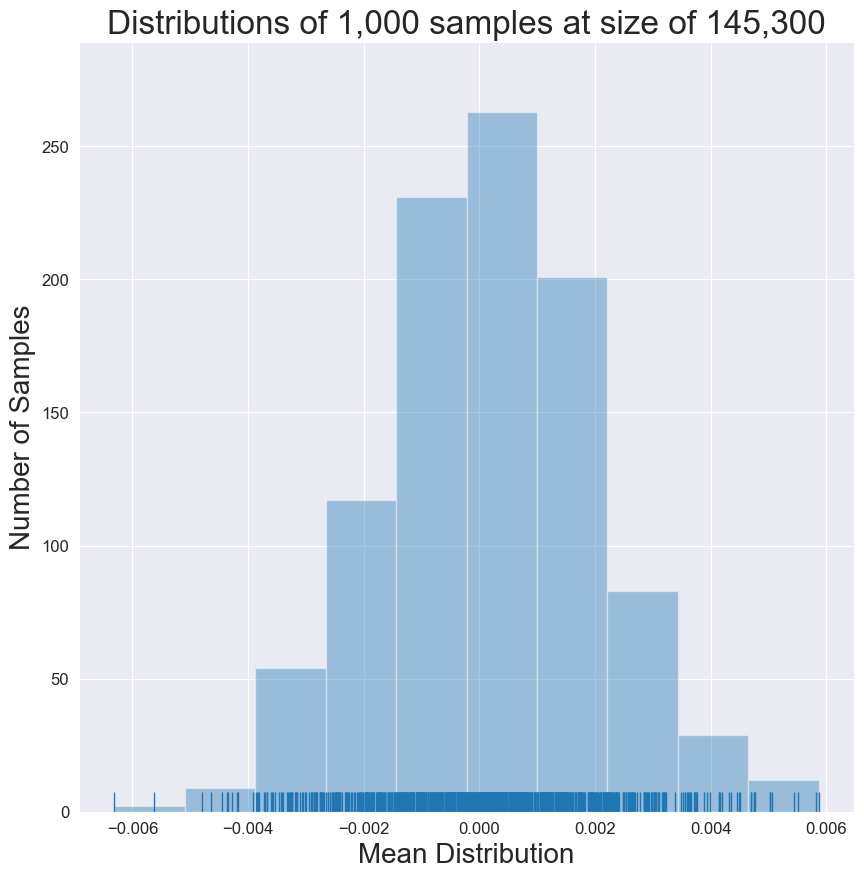

In [118]:
plt.figure(figsize=(10,10))
sns.distplot(p_diffs, bins=10, kde=False, rug=True);

plt.xlabel('Mean Distribution', fontsize=20)
plt.title('Distributions of 1,000 samples at size of 145,300', fontsize=24)
plt.ylabel('Number of Samples', fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

In [120]:
np.mean(p_diffs)

0.00014653120799652794

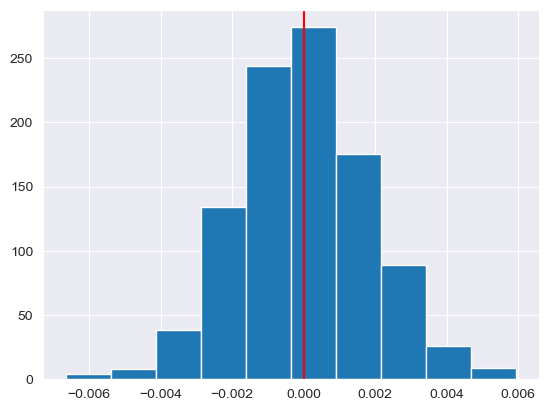

In [121]:
p_diffs = np.array(p_diffs)
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)
plt.hist(null_vals);
plt.axvline(x=obs_diff, color='red');

In [122]:
(null_vals > obs_diff).mean()

0.5004995004995005

In [125]:
actual_new_conv = df[df.landing_page == 'new_page']['converted'].mean()
actual_old_conv = df[df.landing_page == 'old_page']['converted'].mean()

actual_diff = actual_new_conv - actual_old_conv

print(f"Actual difference in new & old conversion means: {actual_diff}")


Actual difference in new & old conversion means: -0.0015790565976871451


In [126]:
diff_prop = np.greater(p_diffs,actual_diff)
# Proportion of p_diffs that are greater than the actual difference observed in ab_data
diff_prop.mean()

0.8331668331668332

Рассчитанное значение, равное приблизительно 0.81, указывает на то, что примерно 81% значений из наших симуляций (p_diffs) оказались более экстремальными, чем фактическое наблюдаемое различие. Это значение используется для оценки того, насколько вероятно получить такое или более экстремальное различие, если бы нулевая гипотеза была истинной. В данном контексте высокая доля указывает на то, что нулевую гипотезу (отсутствие различий между старой и новой страницей) трудно отвергнуть.

z-test attempt as well as setup for stats.proportions_ztest

In [127]:
import statsmodels.api as sm

old_data = df[df.landing_page == 'old_page']['converted']
new_data = df[df.landing_page == 'new_page']['converted']

average_converted_old = df[df.landing_page == 'old_page']['converted'].mean()
average_converted_new = df[df.landing_page == 'new_page']['converted'].mean()

std_converted_old = df[df.landing_page == 'old_page']['converted'].std()
std_converted_new = df[df.landing_page == 'new_page']['converted'].std()

n_old = len(df[df.landing_page == 'old_page'])
n_new = len(df[df.landing_page == 'new_page'])

print(n_old,average_converted_old,std_converted_old)
print(n_new,average_converted_new,std_converted_new)

145274 0.1203863045004612 0.32541384592046235
145311 0.11880724790277405 0.32356267742508843


In [128]:
sm.stats.ztest(old_data,new_data,alternative='two-sided')

(1.3116069027036805, 0.18965280280355812)

In [129]:
sm.stats.proportions_ztest(average_converted_new * n_new, n_new, average_converted_old, alternative='larger')

(-1.860330113957241, 0.9685805822421876)

Значение z-оценки -1.86 говорит о том, что разница между средними конверсиями старой и новой страниц находится на 1.86 стандартных отклонений ниже среднего. Это указывает на то, что средняя конверсия на новой странице ниже средней конверсии на старой странице.

P-значение составляет примерно 0.968, что означает, что 96,8% значений в наших данных более экстремальны, чем наблюдаемое различие, если бы нулевая гипотеза (отсутствие различий) была верна.

Оба этих результата указывают на то, что у нас недостаточно доказательств, чтобы отвергнуть нулевую гипотезу о том, что нет различий в конверсии между старой и новой страницами. Это согласуется с выводами выше